In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from VAE import VAE

import scanpy as sc

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.optim import lr_scheduler

### Binary MNIST

In [ ]:
# binary MNIST
dataset = MNIST('../data/', train=True, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x)), T.Lambda(lambda x: (x>0.5).float())]))

trainloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

vae = VAE(n_features=784, z_dim=32, layer_sizes=[128,128], generative_model='bernoulli', kl_weight=1e-6, is_autoregressive=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=)

In [ ]:
vae.train()
overall_loss_list = []
for epoch in range(30):
    # vae.decoder.update_autoregressive_mask()
    epoch_loss_list = []
    for x, label in trainloader:
        optimizer.zero_grad()

        # one mask for entire batch
        _, _, loss = vae.forward(x)

        elbo = loss[0] + loss[1]
        elbo.backward()
        epoch_loss_list.append(loss[0].detach())
        overall_loss_list.append(loss[0].detach())

        optimizer.step()

    print(f'Epoch {epoch+1} mean loss: {np.mean(epoch_loss_list):.4f}')

In [ ]:
# loss_list_vanilla = overall_loss_list

In [ ]:
plt.figure()
plt.plot(loss_list_vanilla, label='standard VAE')
plt.plot(overall_loss_list, label='AR VAE (one ordering)')
plt.legend()
plt.xlabel('batches')
plt.ylabel('NLL')
plt.ylim([0,0.15])

In [ ]:
from matplotlib import colors

for x, label in trainloader:
    f, ax = plt.subplots(ncols=3, figsize=(14,6))
    ax[0].imshow(x.detach().reshape(-1,28,28)[0], cmap='Greys')
    ax[0].set_title('input')
    
    img = vae(x)[1][0].detach().reshape(-1,28,28)[0]
    ax[1].imshow(img, cmap='Greens', vmax=torch.max(img))
    ax[1].set_title('reconstruction probabilities')

    N = 2
    for n in range(N):
        vae.decoder.update_autoregressive_mask()
        img *= vae(x)[1][0].detach().reshape(-1,28,28)[0]
        img /= torch.sum(img)

    ax[2].imshow(img, cmap='Greens', vmax=torch.max(img))
    ax[2].set_title('averaged probabilities')
    plt.show()
    break

In [ ]:
plt.hist(vae.decoder.output_layers['p'].weight.detach().flatten(), bins=100, log=True);

In [ ]:
plt.imshow(vae.decoder.output_layers['p'].weight.detach())
plt.colorbar();

In [ ]:
out = vae.decoder(torch.zeros(1,32))
plt.imshow(out[0].detach().reshape(28,28))

In [ ]:
X = dataset.data.reshape(-1,784).float()

labels = dataset.targets

In [ ]:
_ = vae.forward(X)

In [ ]:
import umap
import seaborn as sns

reducer = umap.UMAP()

z_umap = reducer.fit_transform(vae.z.detach())

sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], hue=labels)

### Binary gene expression data

In [2]:
data = sc.read_10x_h5('/Users/liam/OneDrive - McGill University/scRNA/data/10x_Genomics_Datasets/pbmc_10k_v3_filtered_feature_bc_matrix.h5')

sc.pp.filter_genes(data, min_cells=3)
sc.pp.log1p(data)

n_genes = 1200

sc.pp.highly_variable_genes(data, n_top_genes=n_genes)
data = data[:,data.var['highly_variable']]

/Users/liam/opt/anaconda3/envs/torch-mps1/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/liam/opt/anaconda3/envs/torch-mps1/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [54]:
# binary single cell data
X = torch.Tensor((data.X.toarray()>0).astype(int)).float()

trainloader = DataLoader(X, batch_size=128, shuffle=True, drop_last=True)

vae = VAE(n_features=n_genes, z_dim=64, layer_sizes=[128,128], generative_model='bernoulli', kl_weight=1e-6, is_autoregressive=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [62]:
vae.train()
overall_loss_list = []
for epoch in range(50):
    vae.decoder.update_autoregressive_mask()
    epoch_loss_list = []
    for x in trainloader:
        optimizer.zero_grad()

        # one mask for entire batch
        _, _, loss = vae.forward(x)

        elbo = loss[0] + loss[1]
        elbo.backward()
        epoch_loss_list.append(loss[0].detach())
        overall_loss_list.append(loss[0].detach())

        optimizer.step()

    print(f'Epoch {epoch+1} mean loss: {np.mean(epoch_loss_list):.4f}')

Epoch 1 mean loss: 0.1684
Epoch 2 mean loss: 0.1616
Epoch 3 mean loss: 0.1633
Epoch 4 mean loss: 0.1605
Epoch 5 mean loss: 0.1567
Epoch 6 mean loss: 0.1564
Epoch 7 mean loss: 0.1570
Epoch 8 mean loss: 0.1579
Epoch 9 mean loss: 0.1542
Epoch 10 mean loss: 0.1550
Epoch 11 mean loss: 0.1569
Epoch 12 mean loss: 0.1589
Epoch 13 mean loss: 0.1573
Epoch 14 mean loss: 0.1544
Epoch 15 mean loss: 0.1518
Epoch 16 mean loss: 0.1545
Epoch 17 mean loss: 0.1506
Epoch 18 mean loss: 0.1511
Epoch 19 mean loss: 0.1513
Epoch 20 mean loss: 0.1500
Epoch 21 mean loss: 0.1524
Epoch 22 mean loss: 0.1521
Epoch 23 mean loss: 0.1515
Epoch 24 mean loss: 0.1490
Epoch 25 mean loss: 0.1493
Epoch 26 mean loss: 0.1498
Epoch 27 mean loss: 0.1484
Epoch 28 mean loss: 0.1496
Epoch 29 mean loss: 0.1489
Epoch 30 mean loss: 0.1469
Epoch 31 mean loss: 0.1491
Epoch 32 mean loss: 0.1479
Epoch 33 mean loss: 0.1479
Epoch 34 mean loss: 0.1477
Epoch 35 mean loss: 0.1501
Epoch 36 mean loss: 0.1477
Epoch 37 mean loss: 0.1483
Epoch 38 m

In [63]:
reconstruction = vae.forward(X)[1][0].detach()

data_latent = sc.AnnData(X=vae.z.detach().numpy(), obs=data.obs)

In [64]:
corr_ar = torch.abs(torch.corrcoef(reconstruction.T)).numpy().copy()

In [65]:
corr_diff = corr_ar - corr_vanilla

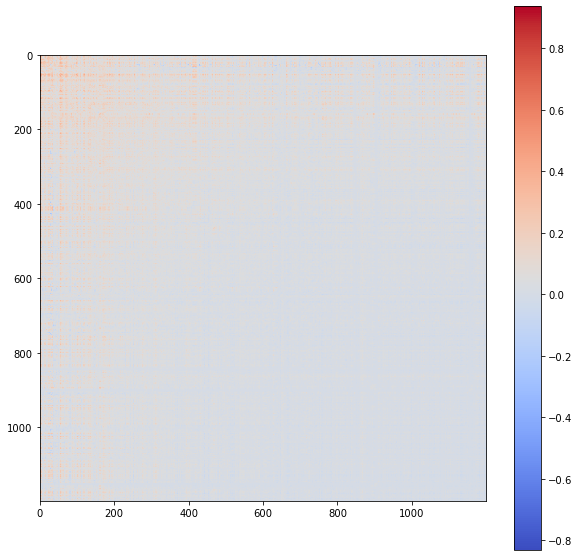

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(corr_diff, cmap='coolwarm')
plt.colorbar()

Text(0.5, 0, 'correlation difference (ar - vanilla)')

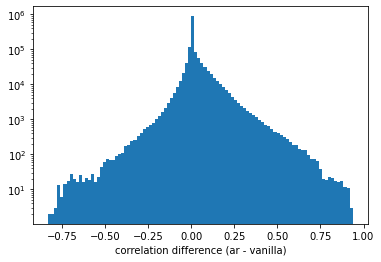

In [69]:
plt.hist(np.triu(corr_diff,k=1).flatten(), bins=100, log=True);
plt.xlabel('correlation difference (ar - vanilla)')

In [68]:
np.mean(np.triu(corr_diff,k=1))

0.018277628

In [ ]:
import umap

reducer = umap.UMAP()

z_umap = reducer.fit_transform(vae.z.detach())

plt.scatter(z_umap[:,0], z_umap[:,1])